## Data Preperation

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#  Load the dataset
file_path = "D:\Coding\Energy-Management_Project\data\data_15min.csv"
df = pd.read_csv(file_path)

In [3]:
print("Initial shape:", df.shape)
print(df.dtypes)
print(df.isnull().sum().head())  # Show top missing values

Initial shape: (153810, 71)
utc_timestamp                          object
cet_cest_timestamp                     object
DE_KN_industrial1_grid_import         float64
DE_KN_industrial1_pv_1                float64
DE_KN_industrial1_pv_2                float64
                                       ...   
DE_KN_residential6_grid_export        float64
DE_KN_residential6_grid_import        float64
DE_KN_residential6_pv                 float64
DE_KN_residential6_washing_machine    float64
Unnamed: 70                            object
Length: 71, dtype: object
utc_timestamp                        0
cet_cest_timestamp                   0
DE_KN_industrial1_grid_import    88080
DE_KN_industrial1_pv_1           84659
DE_KN_industrial1_pv_2           84659
dtype: int64


In [4]:
# Convert timestamp to datetime and set index
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True, errors='coerce')
df.set_index('utc_timestamp', inplace=True)

In [5]:
df.columns

Index(['cet_cest_timestamp', 'DE_KN_industrial1_grid_import',
       'DE_KN_industrial1_pv_1', 'DE_KN_industrial1_pv_2',
       'DE_KN_industrial2_grid_import', 'DE_KN_industrial2_pv',
       'DE_KN_industrial2_storage_charge',
       'DE_KN_industrial2_storage_decharge', 'DE_KN_industrial3_area_offices',
       'DE_KN_industrial3_area_room_1', 'DE_KN_industrial3_area_room_2',
       'DE_KN_industrial3_area_room_3', 'DE_KN_industrial3_area_room_4',
       'DE_KN_industrial3_compressor', 'DE_KN_industrial3_cooling_aggregate',
       'DE_KN_industrial3_cooling_pumps', 'DE_KN_industrial3_dishwasher',
       'DE_KN_industrial3_ev', 'DE_KN_industrial3_grid_import',
       'DE_KN_industrial3_machine_1', 'DE_KN_industrial3_machine_2',
       'DE_KN_industrial3_machine_3', 'DE_KN_industrial3_machine_4',
       'DE_KN_industrial3_machine_5', 'DE_KN_industrial3_pv_facade',
       'DE_KN_industrial3_pv_roof', 'DE_KN_industrial3_refrigerator',
       'DE_KN_industrial3_ventilation', 'DE_KN_public1

In [6]:
# Filter only the required column

target_col = 'DE_KN_residential1_heat_pump'
df = df[[target_col]].copy()

In [7]:
# Rename target column
df.rename(columns={target_col: 'r1_hp'}, inplace=True)

In [8]:
# Drop missing value
df.dropna(inplace=True)

In [9]:
# check
print("Data after cleaning:")
print(df.head())
print("Data range:", df.index.min(), "to", df.index.max())
print("Data frequency check (first 5 diffs):\n", df.index.to_series().diff().head())

Data after cleaning:
                           r1_hp
utc_timestamp                   
2015-05-21 15:30:00+00:00  0.000
2015-05-21 15:45:00+00:00  0.010
2015-05-21 16:00:00+00:00  0.010
2015-05-21 16:15:00+00:00  0.010
2015-05-21 16:30:00+00:00  0.308
Data range: 2015-05-21 15:30:00+00:00 to 2017-03-12 23:00:00+00:00
Data frequency check (first 5 diffs):
 utc_timestamp
2015-05-21 15:30:00+00:00               NaT
2015-05-21 15:45:00+00:00   0 days 00:15:00
2015-05-21 16:00:00+00:00   0 days 00:15:00
2015-05-21 16:15:00+00:00   0 days 00:15:00
2015-05-21 16:30:00+00:00   0 days 00:15:00
Name: utc_timestamp, dtype: timedelta64[ns]


### Convert cumulative data into actual per-interval usage

In [10]:
# Convert cumulative to actual usage
df['r1_hp'] = df['r1_hp'].diff()

# Drop the first row which becomes NaN after diff
df.dropna(inplace=True)

In [11]:
# Optional sanity check for negative values
print("Negative values count:", (df['r1_hp'] < 0).sum())


df = df[df['r1_hp'] >= 0]  # or df['r1_hp'] = df['r1_hp'].clip(lower=0)

Negative values count: 0


### 60 min interval

In [11]:
# Resample to 60-minute frequency by summing up 15-minute values
df = df.resample('60min').sum()

# Drop rows with missing or all-zero values if needed
df = df[df['r1_hp'] > 0]  # optional, depending on your goal


## Data Viz

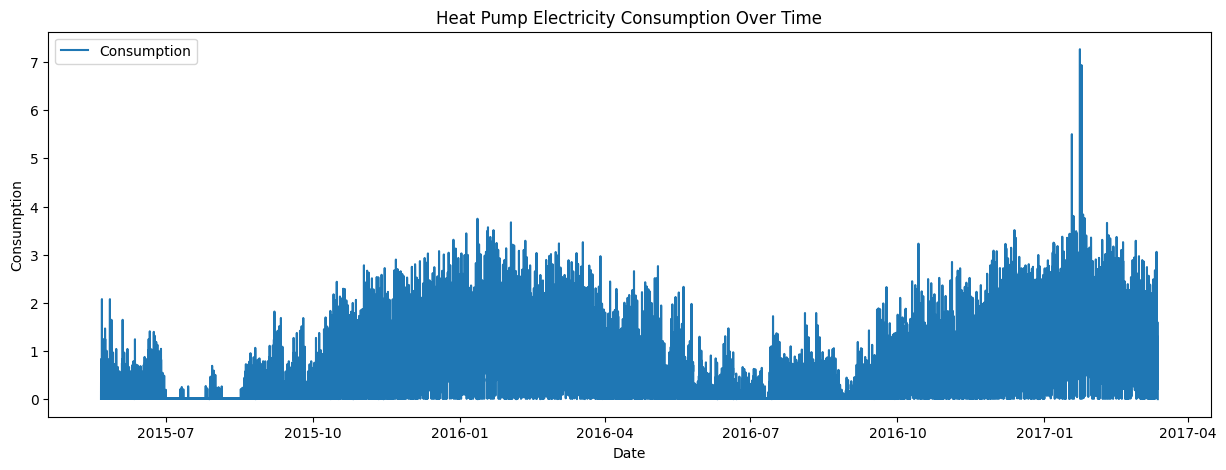

In [12]:
#Plot the time series consumption
plt.figure(figsize=(15,5))
plt.plot(df.index, df['r1_hp'], label='Consumption')
plt.title('Heat Pump Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

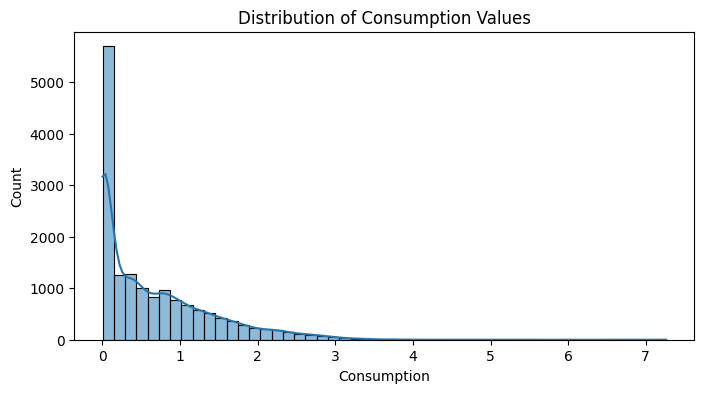

In [13]:
# Distribution plot of consumption
plt.figure(figsize=(8,4))
sns.histplot(df['r1_hp'], bins=50, kde=True)
plt.title('Distribution of Consumption Values')
plt.xlabel('Consumption')
plt.show()

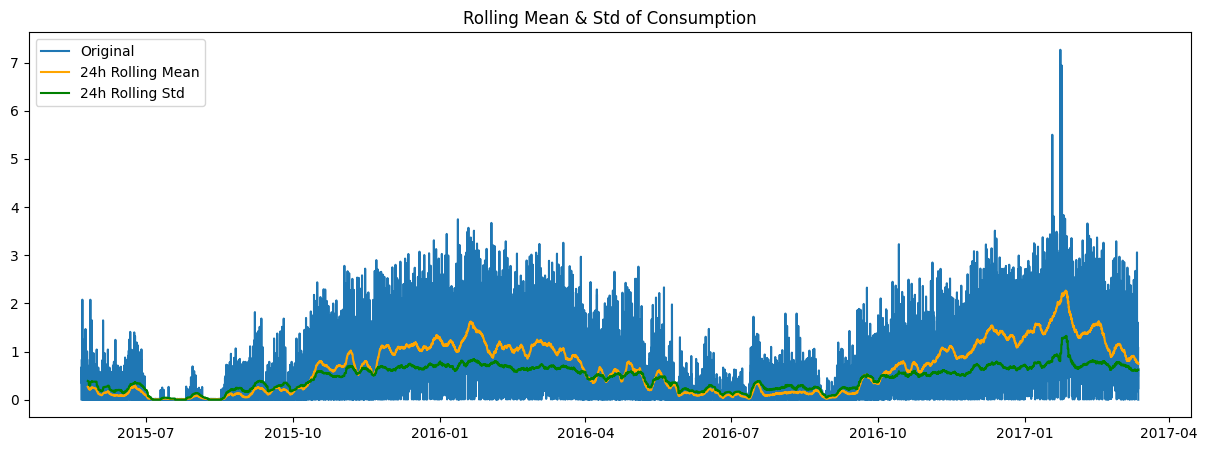

In [14]:
# Rolling mean and rolling std to check trend and seasonality

rolling_window = 96  # 96 * 15min = 24 hours
plt.figure(figsize=(15,5))
plt.plot(df['r1_hp'], label='Original')
plt.plot(df['r1_hp'].rolling(window=rolling_window).mean(), label='24h Rolling Mean', color='orange')
plt.plot(df['r1_hp'].rolling(window=rolling_window).std(), label='24h Rolling Std', color='green') 
plt.title('Rolling Mean & Std of Consumption')
plt.legend()
plt.show()

## Time-Series Viz

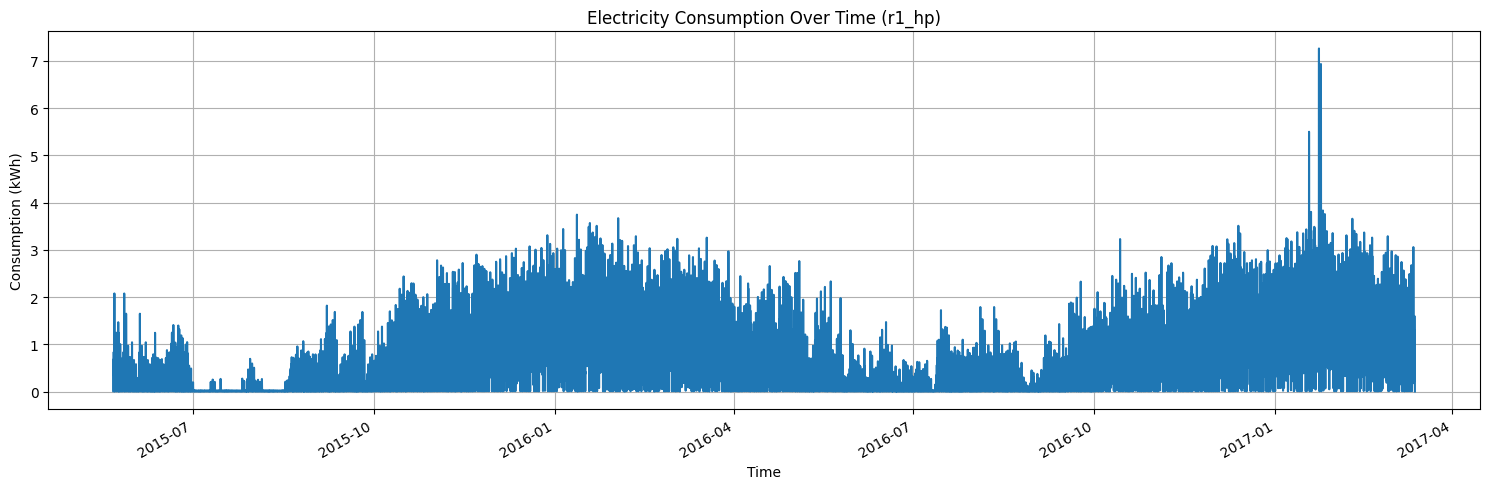

In [15]:
plt.figure(figsize=(15,5))
df['r1_hp'].plot()
plt.title("Electricity Consumption Over Time (r1_hp)")
plt.ylabel("Consumption (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

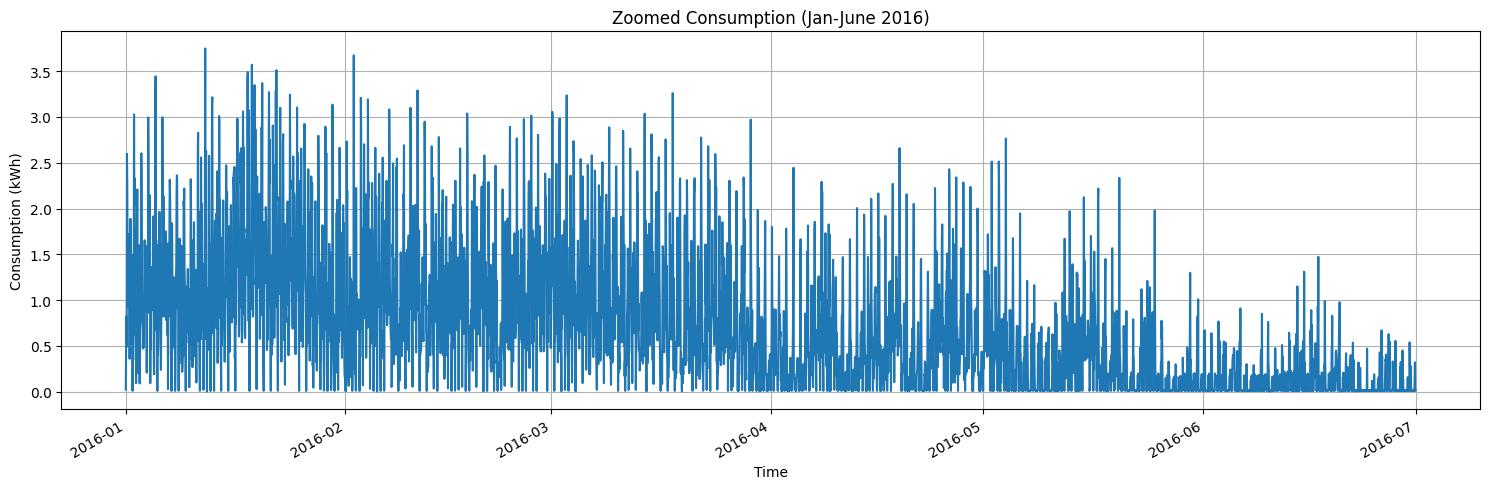

In [16]:
df_zoom = df['2016-01-01':'2016-06-30']
plt.figure(figsize=(15,5))
df_zoom['r1_hp'].plot()
plt.title("Zoomed Consumption (Jan-June 2016)")
plt.ylabel("Consumption (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


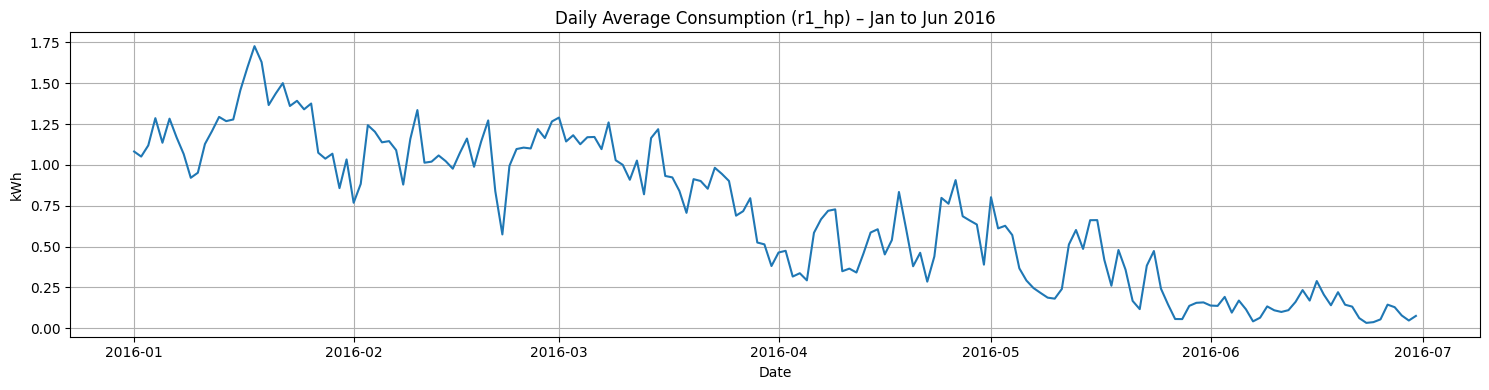

In [23]:
# Resample to daily average consumption
df_daily = df['r1_hp'].resample('D').mean()

# Filter for Jan to Jun 2016
df_daily_subset = df_daily.loc['2016-01-01':'2016-06-30']

# Plot
plt.figure(figsize=(15,4))
plt.plot(df_daily_subset.index, df_daily_subset.values)
plt.title("Daily Average Consumption (r1_hp) – Jan to Jun 2016")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

## Adding ON/OFF Column

In [17]:
# Create ON/OFF column: 1 if heat pump was ON, 0 if OFF
# It works fine, but:It might be too sensitive to noise (e.g., 0.001 kWh is not meaningful). Might misclassify short spikes or drops in cumulative readings.
# so chose to consider 0.01 as threshold instead of 0

threshold = 0.04
df['r1_hp_onoff'] = (df['r1_hp'] > threshold).astype(int)

In [18]:
# Check result
print(df[['r1_hp', 'r1_hp_onoff']].head(20))
print("\nValue counts:")
print(df['r1_hp_onoff'].value_counts())

                           r1_hp  r1_hp_onoff
utc_timestamp                                
2015-05-21 15:00:00+00:00  0.010            0
2015-05-21 16:00:00+00:00  0.500            1
2015-05-21 17:00:00+00:00  0.349            1
2015-05-21 18:00:00+00:00  0.590            1
2015-05-21 19:00:00+00:00  0.684            1
2015-05-21 20:00:00+00:00  0.508            1
2015-05-21 21:00:00+00:00  0.839            1
2015-05-21 22:00:00+00:00  0.270            1
2015-05-21 23:00:00+00:00  0.020            0
2015-05-22 00:00:00+00:00  0.009            0
2015-05-22 01:00:00+00:00  0.012            0
2015-05-22 02:00:00+00:00  0.020            0
2015-05-22 03:00:00+00:00  0.347            1
2015-05-22 04:00:00+00:00  1.644            1
2015-05-22 05:00:00+00:00  2.079            1
2015-05-22 06:00:00+00:00  0.340            1
2015-05-22 07:00:00+00:00  0.009            0
2015-05-22 08:00:00+00:00  0.590            1
2015-05-22 09:00:00+00:00  0.280            1
2015-05-22 10:00:00+00:00  0.009  

In [19]:
# Count total ON and OFF states
on_off_counts = df['r1_hp_onoff'].value_counts().rename(index={0: 'OFF', 1: 'ON'})

print("Heat Pump ON/OFF Summary:")
print(on_off_counts)

Heat Pump ON/OFF Summary:
r1_hp_onoff
ON     10441
OFF     5396
Name: count, dtype: int64


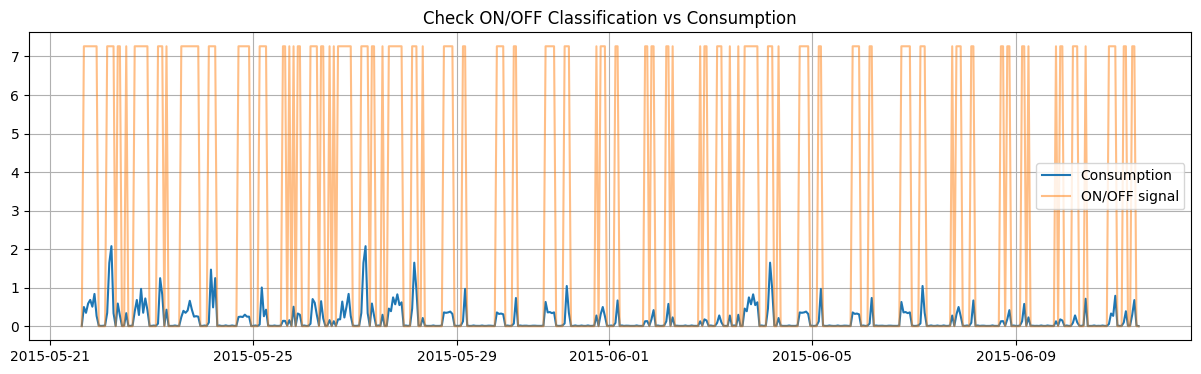

In [20]:
# ON/OFF Plot

plt.figure(figsize=(15,4))
plt.plot(df.index[:500], df['r1_hp'][:500], label="Consumption")
plt.plot(df.index[:500], df['r1_hp_onoff'][:500]*df['r1_hp'].max(), label="ON/OFF signal", alpha=0.5)
plt.legend()
plt.title("Check ON/OFF Classification vs Consumption")
plt.grid(True)
plt.show()

In [21]:
# Check the distribution of r1_hp when ON

print(df[df['r1_hp_onoff'] == 1]['r1_hp'].describe())
print("\nVery low ON readings (< 0.04 kWh):", (df['r1_hp'] < threshold).sum())

count    10441.000000
mean         0.971535
std          0.702938
min          0.040000
25%          0.411000
50%          0.811000
75%          1.353000
max          7.264000
Name: r1_hp, dtype: float64

Very low ON readings (< 0.04 kWh): 5396


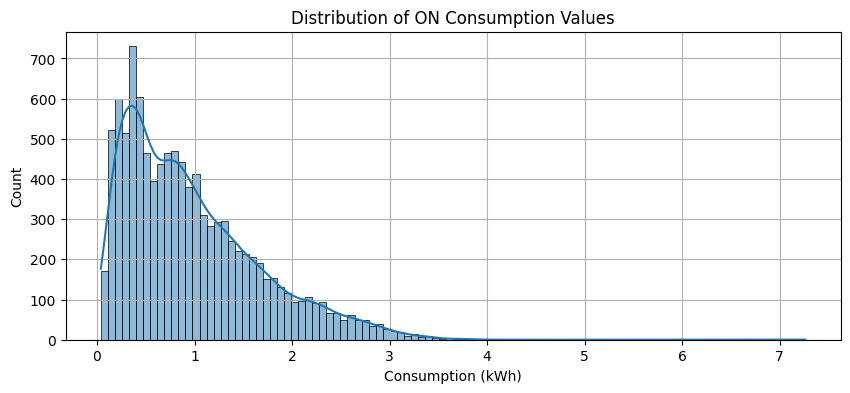

In [22]:
# Plot histogram of ON consumption

import seaborn as sns
plt.figure(figsize=(10,4))
sns.histplot(df[df['r1_hp_onoff'] == 1]['r1_hp'], bins=100, kde=True)
plt.title("Distribution of ON Consumption Values")
plt.xlabel("Consumption (kWh)")
plt.grid(True)
plt.show()

## Feature Creation(Date time feautures)

In [24]:
# time-based features from your datetime index to help the model learn patterns related to when the appliance tends to be ON or OFF.

df_feat = df.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['quarter'] = df_feat.index.quarter
df_feat['month'] = df_feat.index.month
df_feat['year'] = df_feat.index.year
df_feat['dayofyear'] = df_feat.index.dayofyear
df_feat['dayofmonth'] = df_feat.index.day
df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)


In [25]:
# Check the new dataframe structure and sample values
print(df_feat.head())

                           r1_hp  r1_hp_onoff  hour  dayofweek  quarter  \
utc_timestamp                                                             
2015-05-21 15:00:00+00:00  0.010            0    15          3        2   
2015-05-21 16:00:00+00:00  0.500            1    16          3        2   
2015-05-21 17:00:00+00:00  0.349            1    17          3        2   
2015-05-21 18:00:00+00:00  0.590            1    18          3        2   
2015-05-21 19:00:00+00:00  0.684            1    19          3        2   

                           month  year  dayofyear  dayofmonth  weekofyear  
utc_timestamp                                                              
2015-05-21 15:00:00+00:00      5  2015        141          21          21  
2015-05-21 16:00:00+00:00      5  2015        141          21          21  
2015-05-21 17:00:00+00:00      5  2015        141          21          21  
2015-05-21 18:00:00+00:00      5  2015        141          21          21  
2015-05-21 19:00:0

## Visualize Feature-Target Relationship (for ON data only)

In [26]:
# Filter ON rows only, to analyze when and how much energy is Used

df_on = df[df['r1_hp_onoff'] == 1].copy()

In [27]:
# Create time features for df_on

df_on['hour'] = df_on.index.hour  # extract the Hours(0 to 23)
df_on['dayofweek'] = df_on.index.dayofweek  # extract the day of week (0= Monday to 6 = Sunday)

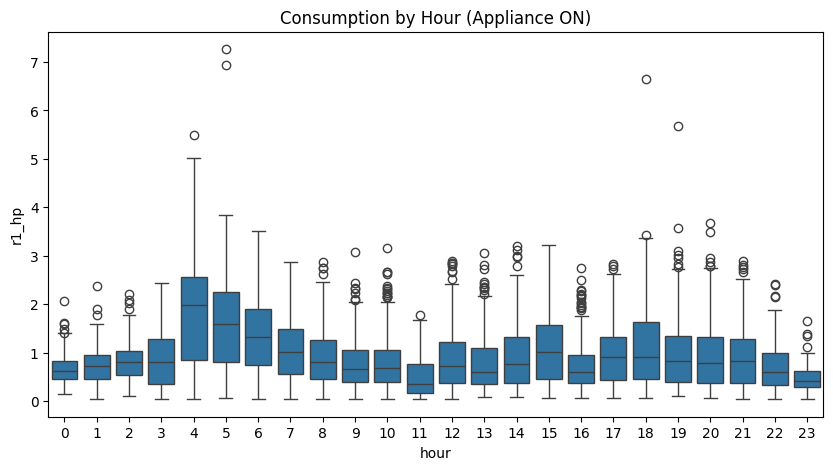

In [28]:
# distribution of consumption during each hour of the day

plt.figure(figsize=(10,5))
sns.boxplot(x='hour', y='r1_hp', data=df_on)
plt.title('Consumption by Hour (Appliance ON)')
plt.show()

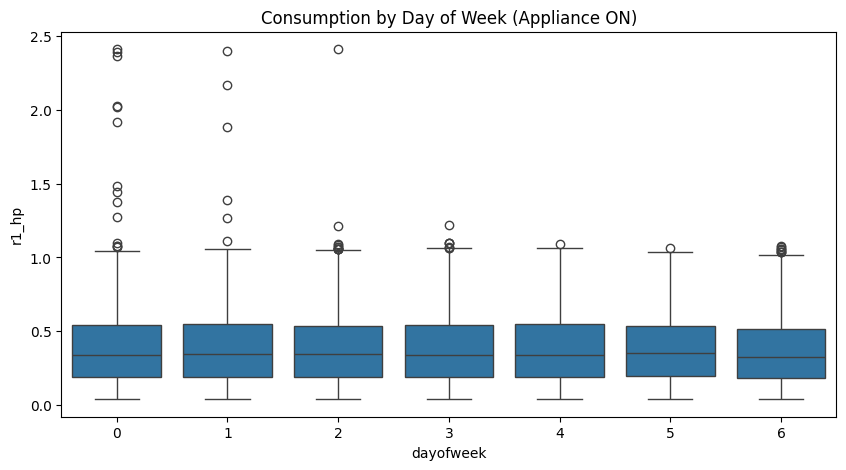

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(x='dayofweek', y='r1_hp', data=df_on)
plt.title('Consumption by Day of Week (Appliance ON)')
plt.show()

In [29]:
# Group-wise statistics (mean, median, std) of consumption by hour


df_on.groupby('hour')['r1_hp'].agg(['mean', 'median', 'std', 'count'])

,mean,median,std,count
hour,,,,
0,0.668687,0.6175,0.315978,284
1,0.746568,0.7330,0.333325,338
2,0.817332,0.8050,0.363827,355
3,0.869545,0.8150,0.555887,617
4,1.785614,1.9900,0.995146,609
5,1.574120,1.5850,0.925191,557
6,1.344152,1.3190,0.770099,481
7,1.082885,1.0080,0.641797,436
8,0.905328,0.8015,0.573810,412


In [30]:
# Summary statistics of consumption by day of week

df_on.groupby('dayofweek')['r1_hp'].describe()

,count,mean,std,min,25%,50%,75%,max
dayofweek,,,,,,,,
0,1463.0,0.983031,0.740495,0.041,0.42200,0.811,1.35550,7.264
1,1465.0,0.988621,0.727441,0.040,0.41000,0.840,1.38900,6.935
2,1478.0,0.984862,0.708776,0.045,0.41175,0.830,1.36775,5.501
3,1514.0,0.970682,0.695161,0.046,0.42000,0.800,1.37500,3.805
4,1488.0,0.978032,0.700493,0.046,0.41675,0.820,1.35950,3.510
5,1470.0,0.967613,0.687060,0.043,0.41000,0.810,1.36150,3.451
6,1563.0,0.930486,0.660974,0.052,0.40000,0.778,1.29950,3.351


In [31]:
# Count how many times the heat pump is ON in each hour (ON frequency)

df['r1_hp_onoff'].groupby(df.index.hour).sum()

utc_timestamp
0     284
1     338
2     355
3     617
4     609
5     557
6     481
7     436
8     412
9     396
10    314
11    224
12    392
13    391
14    410
15    392
16    464
17    498
18    522
19    529
20    546
21    553
22    547
23    174
Name: r1_hp_onoff, dtype: int64

## Train Test Split (time order series)

In [32]:
# Define the exact time range for training and testing

train_start = pd.Timestamp("2016-01-01 00:00:00+00:00")
train_end = pd.Timestamp("2016-06-30 23:45:00+00:00")
test_start = pd.Timestamp("2016-07-01 00:00:00+00:00")
test_end = pd.Timestamp("2016-07-07 23:45:00+00:00")

In [33]:
# Create boolean masks that are True when the row timestamp falls within train/test periods
# These masks ensure only rows within the date range are selected.

train_mask = (df_feat.index >= train_start) & (df_feat.index <= train_end)
test_mask = (df_feat.index >= test_start) & (df_feat.index <= test_end)

In [34]:
# Select features and target columns

feature_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
target_col = 'r1_hp_onoff'

In [35]:
# Split the feature matrix and target vector for train and test

X_train = df_feat.loc[train_mask, feature_cols].copy()
y_train = df_feat.loc[train_mask, 'r1_hp_onoff']

X_test = df_feat.loc[test_mask, feature_cols].copy()
y_test = df_feat.loc[test_mask, 'r1_hp_onoff']

In [36]:
# Print shapes and summary counts to verify

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train ON count: {y_train.sum()}, Test ON count: {y_test.sum()}")

Train shape: (4364, 8), Test shape: (168, 8)
Train ON count: 3372, Test ON count: 47


In [37]:
# # Create lag and rolling features on X_train and X_test

def create_time_features(df):
    df['lag_1'] = df['r1_hp'].shift(1)  # 1 day lag
    df['lag_2'] = df['r1_hp'].shift(2)  # 2 day lag
    
    df['rolling_mean_4'] = df['r1_hp'].rolling(window=4).mean()  # 4-day rolling mean
    df['rolling_mean_12'] = df['r1_hp'].rolling(window=12).mean()  # 12-day rolling mean
    
    df['rolling_std_4'] = df['r1_hp'].rolling(window=4).std()  # 4-day std
    df['rolling_std_12'] = df['r1_hp'].rolling(window=12).std()  # 12-day std
    
    df.fillna(0, inplace=True)
    return df

In [38]:
# Add lag and rolling features for daily data (1 row = 1 day)

df_feat['lag_1'] = df_feat['r1_hp'].shift(1).fillna(0)  # Yesterday's consumption
df_feat['lag_2'] = df_feat['r1_hp'].shift(2).fillna(0)  # 2 days ago

df_feat['rolling_mean_4'] = df_feat['r1_hp'].rolling(window=4).mean().fillna(0)  # Last 4 days avg
df_feat['rolling_mean_12'] = df_feat['r1_hp'].rolling(window=12).mean().fillna(0)  # Last 12 days avg

df_feat['rolling_std_4'] = df_feat['r1_hp'].rolling(window=4).std().fillna(0)  # Last 4 days std dev
df_feat['rolling_std_12'] = df_feat['r1_hp'].rolling(window=12).std().fillna(0)  # Last 12 days std dev

In [39]:
# Update feature columns list with new features

extended_features = feature_cols + ['lag_1', 'lag_2', 'rolling_mean_4', 'rolling_mean_12', 'rolling_std_4', 'rolling_std_12']

In [40]:
# Prepare final train/test feature sets

X_train = df_feat.loc[train_mask, extended_features]
X_test = df_feat.loc[test_mask, extended_features]

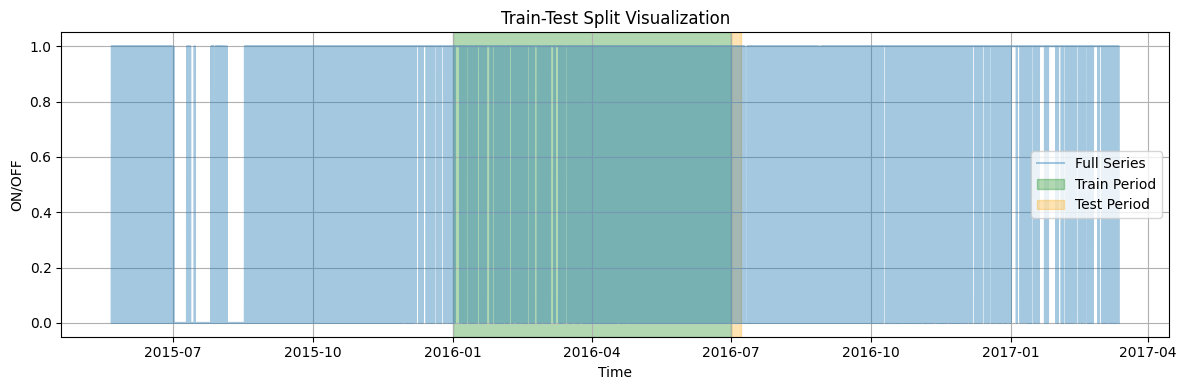

In [41]:
# viz portion of data for training and testing

plt.figure(figsize=(12,4))
plt.plot(df_feat.index, df_feat['r1_hp_onoff'], label='Full Series', alpha=0.4)
plt.axvspan(train_start, train_end, color='green', alpha=0.3, label='Train Period')
plt.axvspan(test_start, test_end, color='orange', alpha=0.3, label='Test Period')
plt.title("Train-Test Split Visualization")
plt.xlabel("Time")
plt.ylabel("ON/OFF")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [42]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True).round(3))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True).round(3))

Train class distribution:
r1_hp_onoff
1    0.773
0    0.227
Name: proportion, dtype: float64

Test class distribution:
r1_hp_onoff
0    0.72
1    0.28
Name: proportion, dtype: float64


## Train-Test Split for ON/OFF Model

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [44]:
# Calculate class imbalance weight

neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

Scale_pos_weight: 3.40


In [45]:
# Initialize the classifier with class balancing

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

In [46]:
# Train the model normally

model.fit(X_train, y_train)

d:\Coding\Energy_Management\em\lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [47]:
# predict ON/OFF TEST

y_pred = model.predict(X_test)

In [48]:
# evaluate model performance

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9404761904761905
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       121
           1       0.91      0.87      0.89        47

    accuracy                           0.94       168
   macro avg       0.93      0.92      0.93       168
weighted avg       0.94      0.94      0.94       168

Confusion Matrix:
 [[117   4]
 [  6  41]]


####

The model is quite reliable at predicting ON/OFF status with strong accuracy and balanced precision/recall.

## Regression model (predict consumption when ON)

In [49]:
# Filter data where heat pump is ON (consumption > 0)

df_reg = df[df['r1_hp_onoff'] == 1].copy()

In [50]:
# Create time-based features again for this subset

df_reg['hour'] = df_reg.index.hour
df_reg['dayofweek'] = df_reg.index.dayofweek
df_reg['quarter'] = df_reg.index.quarter
df_reg['month'] = df_reg.index.month
df_reg['year'] = df_reg.index.year
df_reg['dayofyear'] = df_reg.index.dayofyear
df_reg['dayofmonth'] = df_reg.index.day
df_reg['weekofyear'] = df_reg.index.isocalendar().week.astype(int)

In [51]:
# Define features and target for regression

feature_cols_reg = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
target_col_reg = 'r1_hp'  # Actual consumption values

In [52]:
# Define train/test date ranges (keep consistent with ON/OFF model)
train_mask_reg = (df_reg.index >= train_start) & (df_reg.index <= train_end)
test_mask_reg = (df_reg.index >= test_start) & (df_reg.index <= test_end)

X_train_reg = df_reg.loc[train_mask_reg, feature_cols_reg]
y_train_reg = df_reg.loc[train_mask_reg, target_col_reg]

X_test_reg = df_reg.loc[test_mask_reg, feature_cols_reg]
y_test_reg = df_reg.loc[test_mask_reg, target_col_reg]

In [53]:
# Check shapes

print(f"Regression train shape: {X_train_reg.shape}, test shape: {X_test_reg.shape}")
print(f"Regression train target mean: {y_train_reg.mean():.4f}, test target mean: {y_test_reg.mean():.4f}")

Regression train shape: (3372, 8), test shape: (47, 8)
Regression train target mean: 0.9166, test target mean: 0.3063


## Train and Evaluate the Regression Model

In [54]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [55]:
# Initialize the XGBoost Regressor

reg_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

In [56]:
# Train the model

reg_model.fit(X_train_reg, y_train_reg)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [57]:
# Predict on test data

y_pred_reg = reg_model.predict(X_test_reg)

In [58]:
# Evaluate

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)  # manually compute RMSE
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

In [59]:
print(f"Regression Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Model Evaluation:
RMSE: 0.1484
MAE: 0.1212
R² Score: -0.1107


## Predicting

In [60]:
# Predict on test set

y_test_pred = reg_model.predict(X_test_reg)

In [61]:
# Create DataFrame to hold actual and predicted values with timestamps as index

df_test_compare = pd.DataFrame({
    'Actual Consumption': y_test_reg,
    'Predicted Consumption': y_test_pred
}, index=X_test_reg.index)

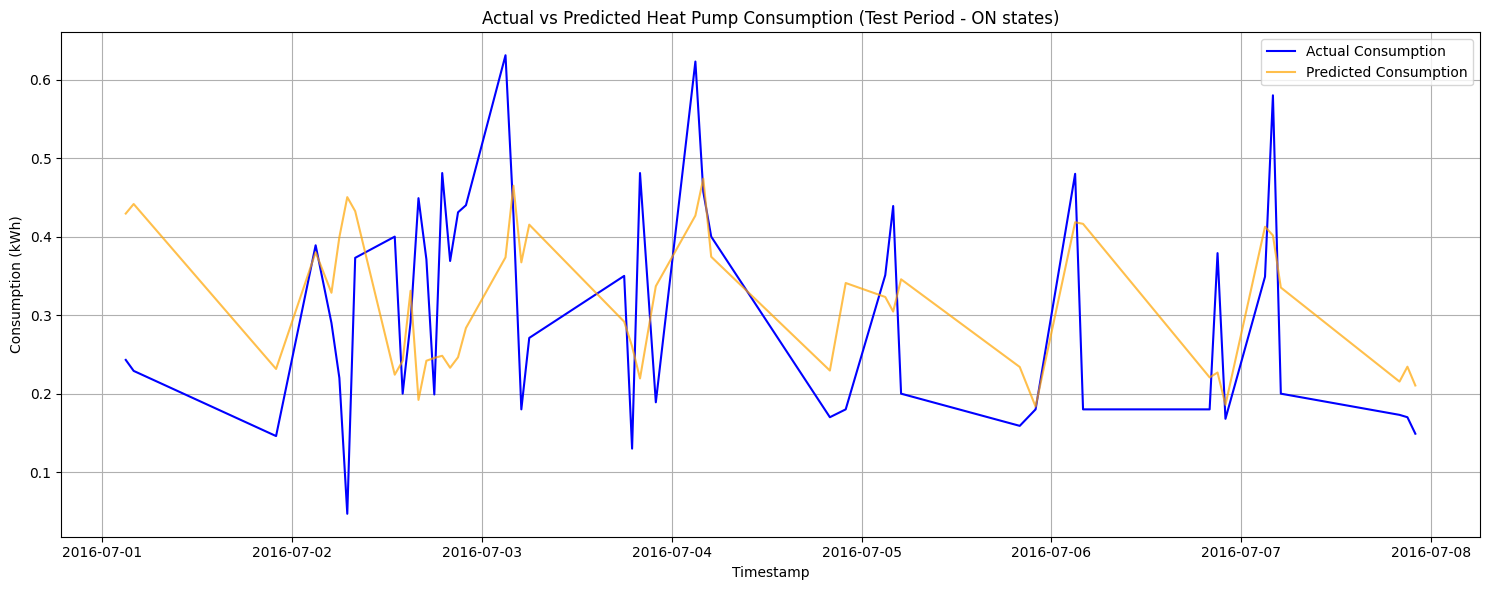

In [62]:
# Plot actual vs predicted

plt.figure(figsize=(15,6))
plt.plot(df_test_compare.index, df_test_compare['Actual Consumption'], label='Actual Consumption', color='blue')
plt.plot(df_test_compare.index, df_test_compare['Predicted Consumption'], label='Predicted Consumption', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Heat Pump Consumption (Test Period - ON states)')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

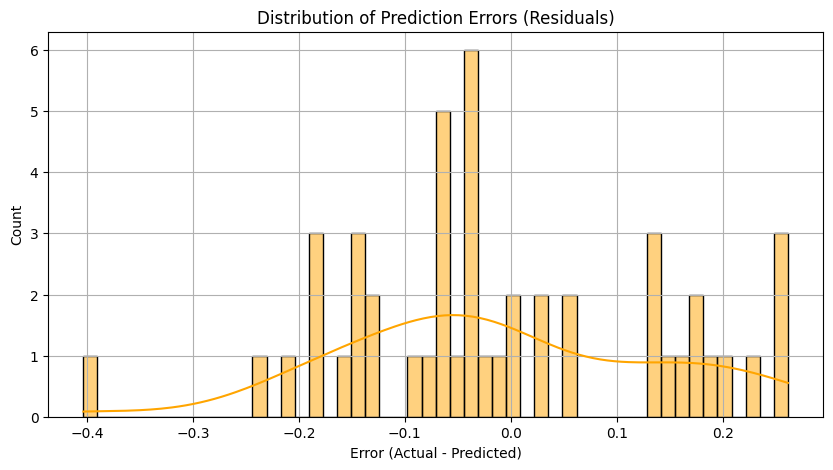

In [63]:
residuals = y_test_reg - y_test_pred
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True, color='orange')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.grid(True)
plt.show()

In [64]:
print("Error summary:")
print(residuals.describe())

Error summary:
count    47.000000
mean     -0.009100
std       0.149697
min      -0.403297
25%      -0.107801
50%      -0.040059
75%       0.131761
max       0.261639
Name: r1_hp, dtype: float64


In [ ]:
# Residuals statistics
residuals = y_test_reg - y_test_pred
print("Residuals summary:")
print(residuals.describe())

Residuals summary:
count    47.000000
mean     -0.009100
std       0.149697
min      -0.403297
25%      -0.107801
50%      -0.040059
75%       0.131761
max       0.261639
Name: r1_hp, dtype: float64


In [66]:
# Residuals correlation with actual values (to check bias)
corr = np.corrcoef(y_test_reg, residuals)[0,1]
print(f"\nCorrelation between actual and residuals: {corr:.4f}")


Correlation between actual and residuals: 0.8172


###
A correlation of 0.8172 between actual values and residuals suggests a strong relationship, which can indicate some bias or patterns still left unexplained by the model. Ideally, residuals should be uncorrelated with actual values (close to zero), meaning errors are random. 

In [67]:
# Baseline model error comparison (naive: predict mean consumption from train set)
baseline_pred = np.full_like(y_test_reg, y_train_reg.mean())
baseline_rmse = np.sqrt(np.mean((y_test_reg - baseline_pred)**2))
model_rmse = np.sqrt(np.mean((y_test_reg - y_test_pred)**2))
print(f"\nBaseline RMSE: {baseline_rmse:.4f}")
print(f"Model RMSE: {model_rmse:.4f}")
print(f"RMSE improvement over baseline: {baseline_rmse - model_rmse:.4f}")


Baseline RMSE: 0.6264
Model RMSE: 0.1484
RMSE improvement over baseline: 0.4780


### 

model is effective at capturing the variability of the target.
RMSE (0.1484) is much lower than the baseline RMSE (0.6264), showing it predicts consumption far better than simply guessing the average.

### Future prediction

In [68]:
# future prediction window

future_start = pd.Timestamp("2016-07-08 00:00:00+00:00")
future_end = pd.Timestamp("2016-07-30 23:45:00+00:00")

df_future = df.copy()
df_future = df_future.loc[future_start:future_end].copy()

In [69]:
# Feature generation

df_future['hour'] = df_future.index.hour
df_future['dayofweek'] = df_future.index.dayofweek
df_future['quarter'] = df_future.index.quarter
df_future['month'] = df_future.index.month
df_future['year'] = df_future.index.year
df_future['dayofyear'] = df_future.index.dayofyear
df_future['dayofmonth'] = df_future.index.day
df_future['weekofyear'] = df_future.index.isocalendar().week.astype(int)

In [70]:
# predict using trained model

X_future = df_future[feature_cols_reg]
df_future['Predicted_r1_hp'] = reg_model.predict(X_future)

In [71]:
print(df_future[['r1_hp', 'Predicted_r1_hp']].head())

                           r1_hp  Predicted_r1_hp
utc_timestamp                                    
2016-07-08 00:00:00+00:00  0.020         0.469004
2016-07-08 01:00:00+00:00  0.010         0.309048
2016-07-08 02:00:00+00:00  0.009         0.351862
2016-07-08 03:00:00+00:00  0.653         0.405806
2016-07-08 04:00:00+00:00  0.238         0.447533


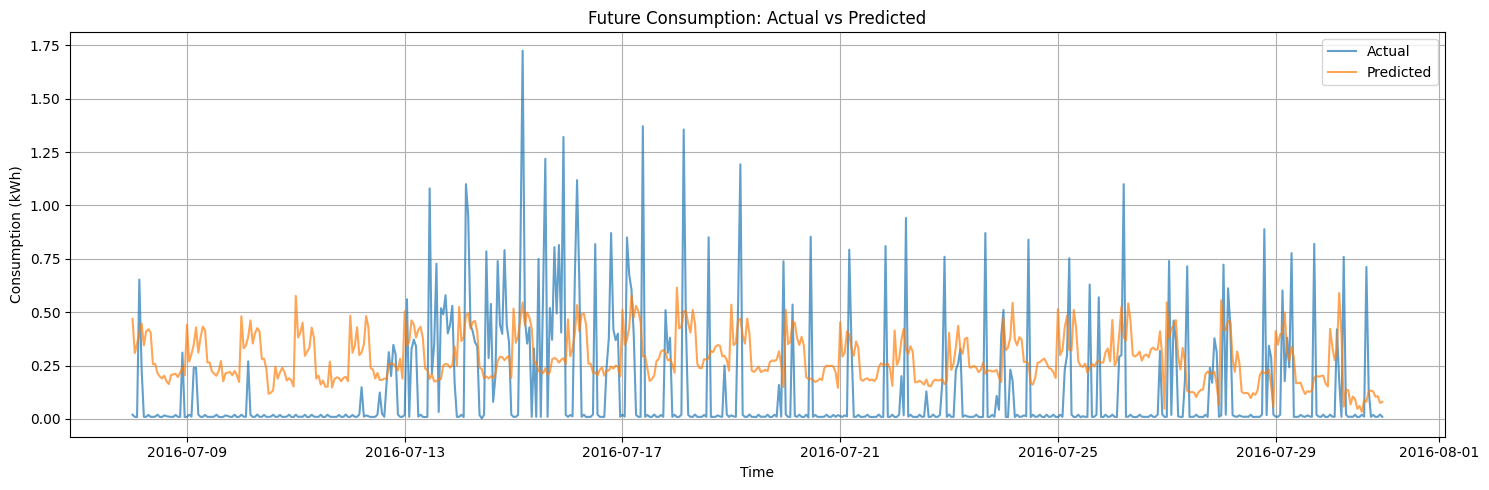

In [72]:
plt.figure(figsize=(15,5))
plt.plot(df_future.index, df_future['r1_hp'], label='Actual', alpha=0.7)
plt.plot(df_future.index, df_future['Predicted_r1_hp'], label='Predicted', alpha=0.7)
plt.title("Future Consumption: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
df_future['Error'] = df_future['r1_hp'] - df_future['Predicted_r1_hp']
print(df_future['Error'].describe())

count    552.000000
mean      -0.140294
std        0.272220
min       -0.606313
25%       -0.290519
50%       -0.198604
75%       -0.105999
max        1.179042
Name: Error, dtype: float64


In [74]:
within_margin = (df_future['Error'].abs() <= 0.1).sum()
total_points = len(df_future)
print(f"Predictions within ±0.1 kWh: {within_margin} out of {total_points} ({(within_margin / total_points * 100):.2f}%)")

Predictions within ±0.1 kWh: 59 out of 552 (10.69%)


###

Standard deviation of errors is smaller for 15-min data, indicating less variability in errors compared to 24-hr data.

Range of errors (min to max) is wider in 60 min data, meaning larger individual errors.

